# ISLP - Chapter 12 - Exercise 9
### Author: pzuehlke

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.datasets import get_rdataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
arrests = get_rdataset("USArrests").data
n, p = arrests.shape
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [3]:
arrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


__9 (a):__ We will use SciPy's `linkage` since it provides more direct access to
the full hierarchical structure of the clustering, which makes it much easier to
visualize and manipulate the dendrogram.

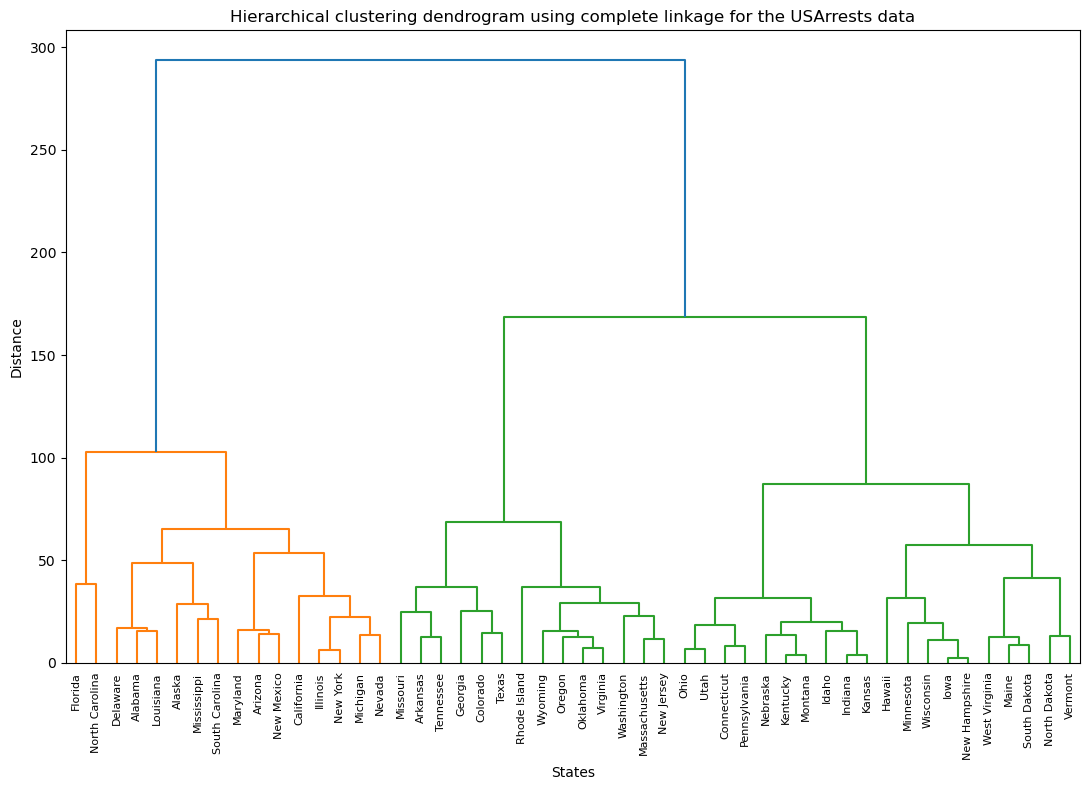

In [4]:
Z = linkage(arrests, method="complete", metric="euclidean")  # complete = using the maximum

# Plot the dendrogram:
fig, ax = plt.subplots(figsize=(11, 8))
dendrogram(Z, labels=arrests.index, leaf_rotation=90)
ax.set_title("Hierarchical clustering dendrogram using complete linkage for the USArrests data")
ax.set_xlabel("States")
ax.set_ylabel("Distance")
plt.tight_layout()
plt.show()

__9 (b):__ We begin by computing the height at which we should cut the
dendrogram in order to obtain $ 3 $ clusters:

In [5]:
# The height for K clusters is at position (n - K) in the sorted heights:
K = 3
# Get all heights from the linkage matrix (third column):
heights = Z[:, 2]
sorted_heights = np.sort(heights)

# The height that gives K clusters is the one where the (n - K)th merge happens
# is sorted_heights[n - K], but we need to use a value a little below that.
# So let's compute the average between the merging heights for 3 and 4 clusters:
cut_height = (sorted_heights[n - K] + sorted_heights[n - K - 1]) / 2

print(f"Cutting height to obtain K = {K} clusters: {cut_height}")

Cutting height to obtain K = 3 clusters: 135.73648730736085


We use `fcluster` from SciPy to cut the dendrogram at this height:

In [6]:
clusters = fcluster(Z, t=cut_height, criterion="distance")  # criterion="distance" to cut by height

Now we add cluster labels to the dataset:

In [7]:
arrests_clustered = arrests.copy()
arrests_clustered["Cluster"] = clusters

Let's print the states in each cluster:

In [8]:
for i in range(1, K + 1):
    cluster_mask = arrests_clustered["Cluster"] == i
    cluster_states = arrests_clustered[cluster_mask].index.tolist()
    print(f"Cluster {i} has {len(cluster_states)} states:")
    print(", ".join(cluster_states))
    print()

Cluster 1 has 16 states:
Alabama, Alaska, Arizona, California, Delaware, Florida, Illinois, Louisiana, Maryland, Michigan, Mississippi, Nevada, New Mexico, New York, North Carolina, South Carolina

Cluster 2 has 14 states:
Arkansas, Colorado, Georgia, Massachusetts, Missouri, New Jersey, Oklahoma, Oregon, Rhode Island, Tennessee, Texas, Virginia, Washington, Wyoming

Cluster 3 has 20 states:
Connecticut, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Minnesota, Montana, Nebraska, New Hampshire, North Dakota, Ohio, Pennsylvania, South Dakota, Utah, Vermont, West Virginia, Wisconsin



Finally, let's visualize these clusters in the dendrogram:

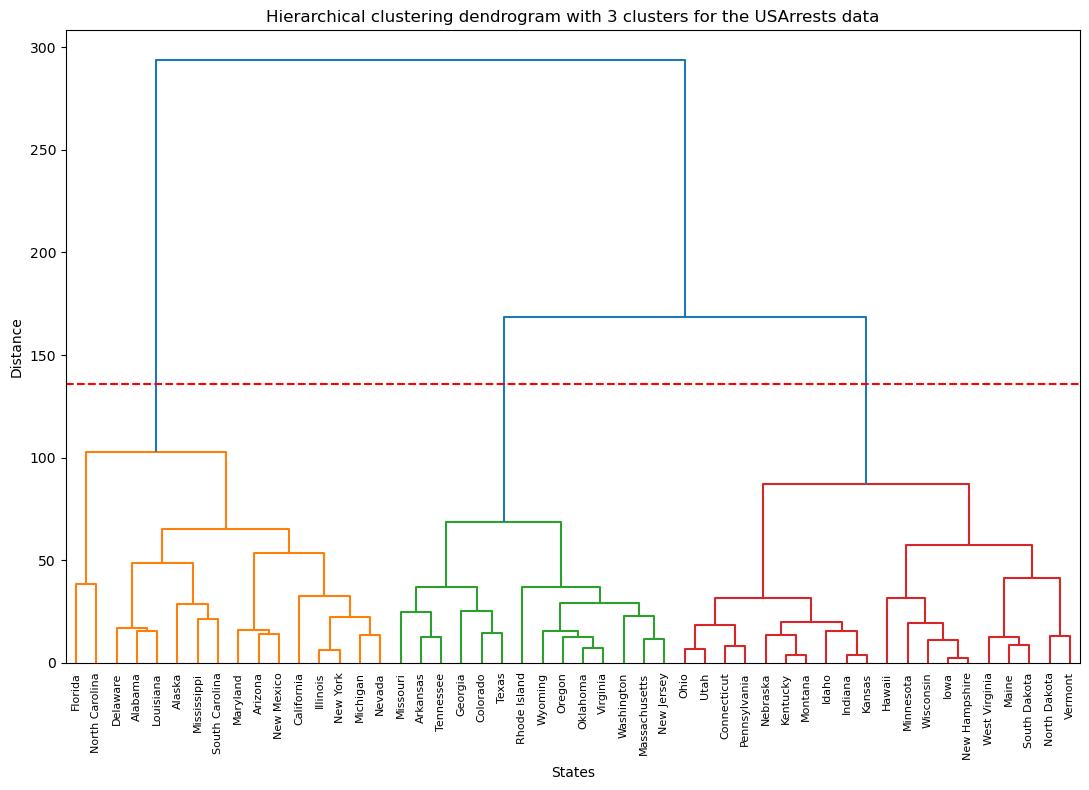

In [9]:
fig, ax = plt.subplots(figsize=(11, 8))
# `color_treshold=cut_height` colors the dendrogram to show the 3 clusters:
dendrogram(Z, labels=arrests.index, color_threshold=cut_height, leaf_rotation=90)
ax.set_title("Hierarchical clustering dendrogram with 3 clusters for the USArrests data")
ax.set_xlabel("States")
ax.set_ylabel("Distance")
ax.axhline(y=cut_height, color="r", linestyle="--")
plt.tight_layout()
plt.show()

__9 (c):__ The solution is almost identical to that of item (a), except we must
first standardize the data:

In [10]:
scaler = StandardScaler()
arrests_scaled = scaler.fit_transform(arrests)

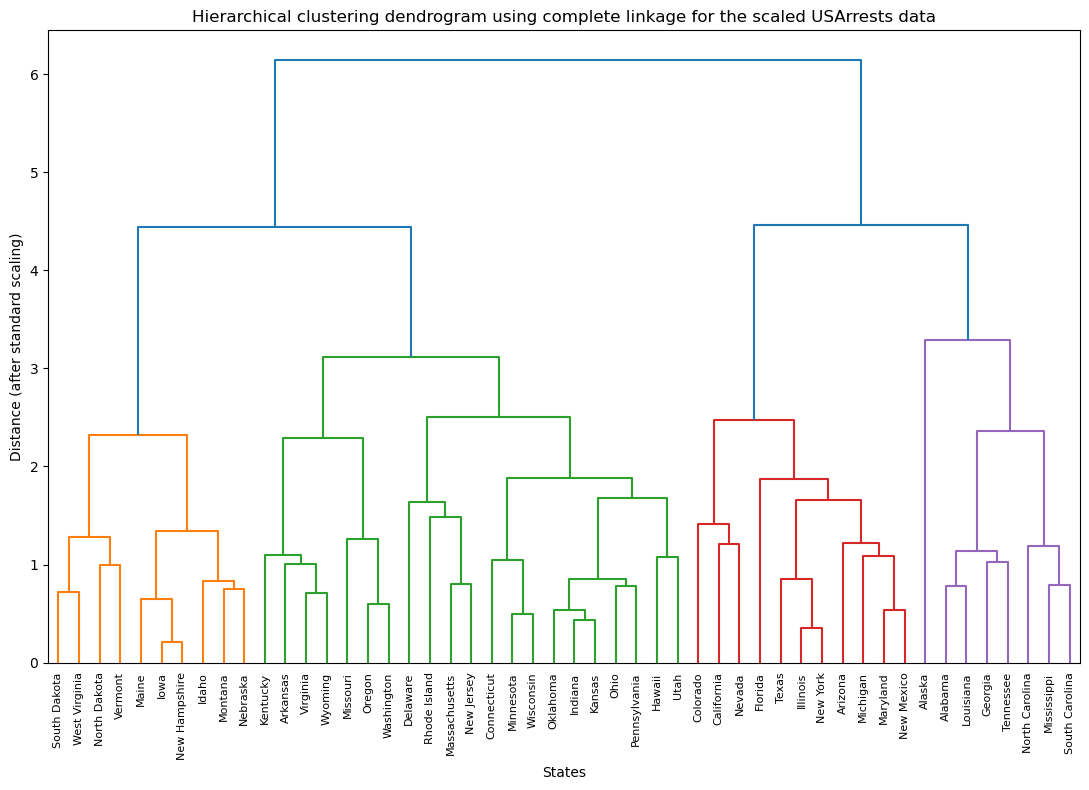

In [13]:
Z_scaled = linkage(arrests_scaled, method="complete", metric="euclidean")

# Plot the dendrogram:
fig, ax = plt.subplots(figsize=(11, 8))
dendrogram(Z_scaled, labels=arrests.index, leaf_rotation=90)
ax.set_title("Hierarchical clustering dendrogram using complete linkage for the scaled USArrests data")
ax.set_xlabel("States")
ax.set_ylabel("Distance (after standard scaling)")
plt.tight_layout()
plt.show()

__9 (d):__ As in Figure 12.4, without scaling we expect that if we cluster the
states using euclidean distance, then the states will basically be grouped by
their `Assault` rates, since this variable's range dominates those of the the
remaining variables, as we can see below:

In [22]:
arrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


An additional reason for performing scaling before clustering is that the units
are different for `UrbanPop` (percentage) versus crime rates (per $ 100,000 $
people).